In [1]:
using Pkg; Pkg.add("BandedMatrices"); Pkg.add("LinearAlgebra"); Pkg.add("Plots")
using BandedMatrices;
using LinearAlgebra;
using Plots;

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %12.6 %                         ]  35.0 % [====================>                    ]  47.6 %]  60.1 %.5 %>       ]  80.1 %======================================>  ]  92.7 % Resolving package versions...
 Installed MatrixFactorizations ─ v0.1.0
 Installed Parsers ────────────── v0.3.7
 Installed OrderedCollections ─── v1.1.0
 Installed DataStructures ─────── v0.17.0
 Installed BandedMatrices ─────── v0.11.1
 Installed Tokenize ───────────── v0.5.6
 Installed Conda ──────────────── v1.3.0
 Installed FillArrays ─────────── v0.7.0
 Installed StaticArrays ───────── v0.11.0
 Installed JSON ───────────────── v0.21.0
 Installed MacroTools ─────────── v0.5.1
 Installed LazyArrays ─────────── v0.11.0
 Installed CSTParser ──────────── v0.6.2
  Updating `~/.julia/environments/v1.0/Project.toml`
  [aae01518] + Ban

┌ Info: Precompiling BandedMatrices [aae01518-5342-5314-be14-df237901396f]
└ @ Base loading.jl:1192
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = ErrorException("Required dependency NaNMath [77ba4419-2d1f-58cd-9bb1-8ffee604a2e3] failed to load from a cache file.")
└ @ Base loading.jl:969


In [38]:
Δx = 0.1; c = 1; Δt1 = 0.1; # Courant number is 1
k1 = c*Δt1/(12*Δx);
k2 = c*Δt1/(2*Δx);
x = -6:Δx:6;
tfinal = 2;
time = 0:Δt1:tfinal;
u = zeros(length(x),length(time));

In [39]:
u0 = zeros(length(x));
for i in 1:length(x)
    u0[i] = exp(-x[i]^2)
end
u[:,1] = u0;

## Define the Matrix

In [40]:
function systemMatrix(k1,k2,n)
    A = BandedMatrix(Eye(n),(2,2));
    A[band(-2)]=k1*ones(length(A[band(-2)])); # fill in the values for sub-diagonal 2
    A[band(-1)]=-8*k1*ones(length(A[band(-1)])); # fill in the values for sub-diagonal 1

    A[band(1)]=8*k1*ones(length(A[band(1)])); # fill in the values for super-diagonal 1
    A[band(2)]=-k1*ones(length(A[band(2)])); # fill in the values for super-diagonal 2

    AA = Matrix(A); # Convert to regular matrix type instead of banded matrix

    # For the first row, Dirichlet boundary condition
    AA[1,2]=0; AA[1,3]=0;

    # For the second and second-to-last rows, implement second-order central difference
    AA[2,1]= -k2; AA[2,3] = k2; AA[2,4] = 0;
    AA[end-1,end] = k2; AA[end-1,end-2]=-k2; AA[end-1,end-3] = 0;

    # For the last row, implement von Neumann boundary condition
    AA[end,end-1]=-1; AA[end,end-2] = 0;

    A= BandedMatrix(AA,(2,2)) # Convert back to banded matrix
    return A;
end

systemMatrix (generic function with 1 method)

In [41]:
rhs = u0;
A1 = systemMatrix(k1,k2,121);
for j in 2:length(time)
    # at each time instant, solve a linear system to find the next step.
    rhs[end]=0;
    u[:,j] = A1\rhs;
    rhs = u[:,j];
end

## Re-calculate everything for different Courant number

In [42]:
Δt2 = 0.5; # Courant number is 1
k1_new = c*Δt2/(12*Δx);
k2_new = c*Δt2/(2*Δx);
x = -6:Δx:6;
tfinal = 2;
time = 0:Δt2:tfinal;
u2 = zeros(length(x),length(time));
u2[:,1] = u0;
rhs = u0;
A2 = systemMatrix(k1_new,k2_new,121);
for j in 2:length(time)
    # at each time instant, solve a linear system to find the next step.
    u2[:,j] = A2\rhs;
    rhs = u2[:,j];
end

### Euler implicit in time, 4th-order central difference in space

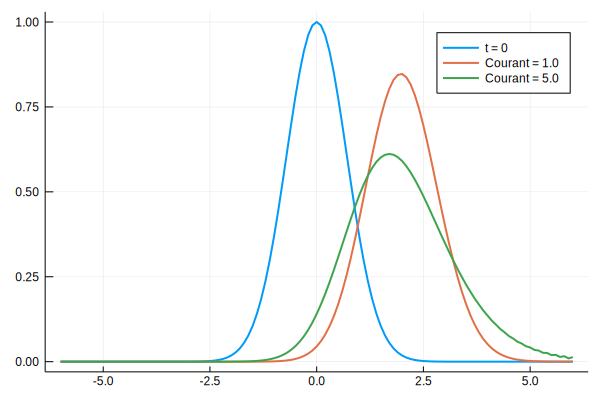

In [52]:
plot(x,hcat(u[:,1],u[:,end],u2[:,end]),label=["t = 0" "Courant = 1.0" "Courant = 5.0"],lw=2)

We see that when Courant = 1.0, the solution is not damped much. When Courant = 5.0, the solution is damped significantly. In both cases, there is some "lag" as the curve is not centered on 2.0 as should be the case according to the wave equation. Some dispersion, i.e. fattening, does happen especially when Courant = 5.0